In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits
PROCESSED = Path("../../data/processed/month_stratified_splits")

try:
    train_df = pd.read_csv(PROCESSED / "train_data.csv")
    val_df = pd.read_csv(PROCESSED / "val_data.csv")
    test_df = pd.read_csv(PROCESSED / "test_data.csv")
    print("✅ Successfully loaded stratified splits")
except FileNotFoundError:
    print("❌ Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")


✅ Successfully loaded stratified splits
Dataset shapes:
Training: (219876, 9)
Validation: (73292, 9)
Test: (73292, 9)


In [3]:
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling"""
    
    # Columns to exclude (metadata and target)
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    
    # Get feature columns (only those present in all datasets)
    common_cols = set(train_df.columns) & set(val_df.columns) & set(test_df.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features:")
    for i, col in enumerate(feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(feature_cols) > 10:
        print(f"  ... and {len(feature_cols) - 10} more features")
    
    # Prepare features and targets
    X_train = train_df[feature_cols]
    y_train = train_df['outage_occurred']
    
    X_val = val_df[feature_cols]
    y_val = val_df['outage_occurred']
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")


Using 5 features:
  1. season
  2. day_name
  3. tmin
  4. prcp
  5. day_of_week
Class distribution in each set:
Training - Outages: 20,636 (9.385%)
Validation - Outages: 6,878 (9.384%)
Test - Outages: 6,879 (9.386%)


In [4]:
# Scale features (helps with gradient boosting convergence)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed")


✅ Feature scaling completed


In [5]:
# Initialize Gradient Boosting model with focus on recall
print("Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(
    n_estimators=150,           # Good balance of performance and training time
    learning_rate=0.1,
    max_depth=5,                # Prevent overfitting while capturing patterns
    min_samples_split=100,      # Conservative to handle class imbalance
    min_samples_leaf=50,        # Conservative to handle class imbalance
    subsample=0.8,              # Stochastic gradient boosting
    random_state=42,
    verbose=1
)

# Train the model
gb_model.fit(X_train_scaled, y_train)
print("✅ Training completed!")

Training Gradient Boosting model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5755           0.0465           37.84s
         2           0.5438           0.0255           31.79s
         3           0.5210           0.0235           29.93s
         4           0.5040           0.0215           29.81s
         5           0.4905           0.0199           31.43s
         6           0.4774           0.0079           32.77s
         7           0.4674           0.0116           34.29s
         8           0.4564           0.0003           35.09s
         9           0.4505           0.0145           35.85s
        10           0.4431           0.0036           36.20s
        20           0.4094           0.0080            1.05m
        30           0.3965           0.0035            1.32m
        40           0.3927          -0.0012            1.51m
        50           0.3922           0.0112            1.54m
        60           0.3869      

In [6]:
# Make predictions on all sets
y_train_pred = gb_model.predict(X_train_scaled)
y_train_proba = gb_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = gb_model.predict(X_val_scaled)
y_val_proba = gb_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = gb_model.predict(X_test_scaled)
y_test_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Comprehensive model evaluation"""
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Most important for outage prediction
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
    
    # Print results
    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} SET EVALUATION")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}  ← Most important for outage prediction")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Class distribution
    print(f"\nClass Distribution:")
    print(f"Class 0 (No Outage): {np.sum(y_true == 0):,} samples")
    print(f"Class 1 (Outage):    {np.sum(y_true == 1):,} samples")
    print(f"Outage Rate: {(np.sum(y_true == 1) / len(y_true)):.3f}")
    
    return metrics

In [7]:
# Evaluate on all datasets
print("GRADIENT BOOSTING MODEL PERFORMANCE")
print("=" * 60)
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "test")


GRADIENT BOOSTING MODEL PERFORMANCE

TRAINING SET EVALUATION
Accuracy:  0.9154
Recall:    0.2406  ← Most important for outage prediction
Precision: 0.6283
F1-Score:  0.3480
ROC-AUC:   0.9146

Class Distribution:
Class 0 (No Outage): 199,240 samples
Class 1 (Outage):    20,636 samples
Outage Rate: 0.094

VALIDATION SET EVALUATION
Accuracy:  0.9126
Recall:    0.2232  ← Most important for outage prediction
Precision: 0.5915
F1-Score:  0.3241
ROC-AUC:   0.9093

Class Distribution:
Class 0 (No Outage): 66,414 samples
Class 1 (Outage):    6,878 samples
Outage Rate: 0.094

TEST SET EVALUATION
Accuracy:  0.9127
Recall:    0.2247  ← Most important for outage prediction
Precision: 0.5912
F1-Score:  0.3257
ROC-AUC:   0.9064

Class Distribution:
Class 0 (No Outage): 66,413 samples
Class 1 (Outage):    6,879 samples
Outage Rate: 0.094


In [8]:
# Create detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['No Outage', 'Outage']))



DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

   No Outage       0.92      0.98      0.95     66413
      Outage       0.59      0.22      0.33      6879

    accuracy                           0.91     73292
   macro avg       0.76      0.60      0.64     73292
weighted avg       0.89      0.91      0.89     73292



CONFUSION MATRIX ANALYSIS


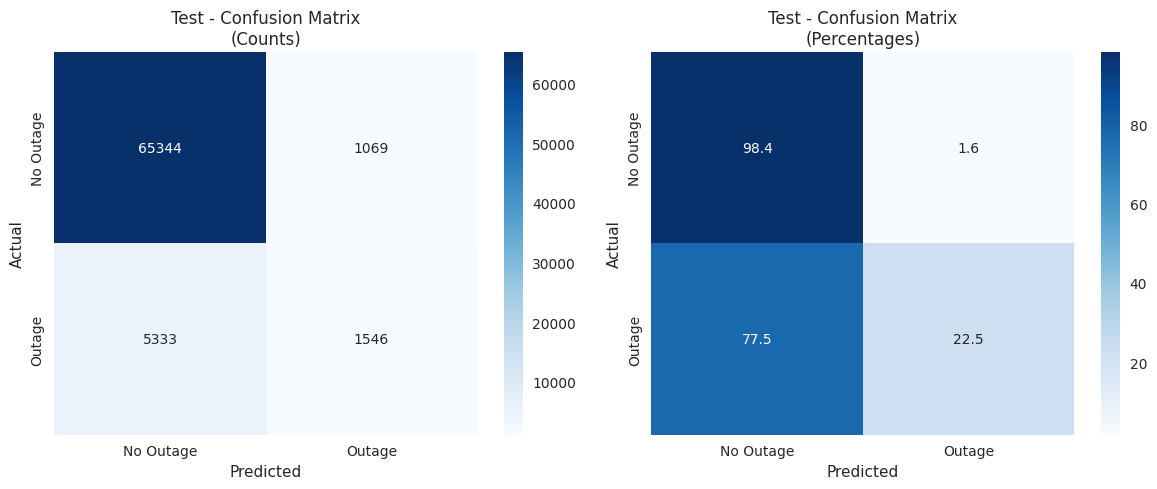


Test Confusion Matrix Insights:
True Negatives (Correct non-outages): 65,344
False Positives (False alarms): 1,069
False Negatives (Missed outages): 5,333 ← Most critical
True Positives (Detected outages): 1,546
Outage Detection Rate: 0.225


In [9]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{dataset_name} - Confusion Matrix\n(Counts)')
    
    # Plot percentages
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title(f'{dataset_name} - Confusion Matrix\n(Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    # Print key confusion matrix insights
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name} Confusion Matrix Insights:")
    print(f"True Negatives (Correct non-outages): {tn:,}")
    print(f"False Positives (False alarms): {fp:,}")
    print(f"False Negatives (Missed outages): {fn:,} ← Most critical")
    print(f"True Positives (Detected outages): {tp:,}")
    print(f"Outage Detection Rate: {tp/(tp+fn):.3f}")
    
    return cm

# Plot confusion matrices for all sets
print("CONFUSION MATRIX ANALYSIS")
print("=" * 50)
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Test")



ROC-AUC ANALYSIS


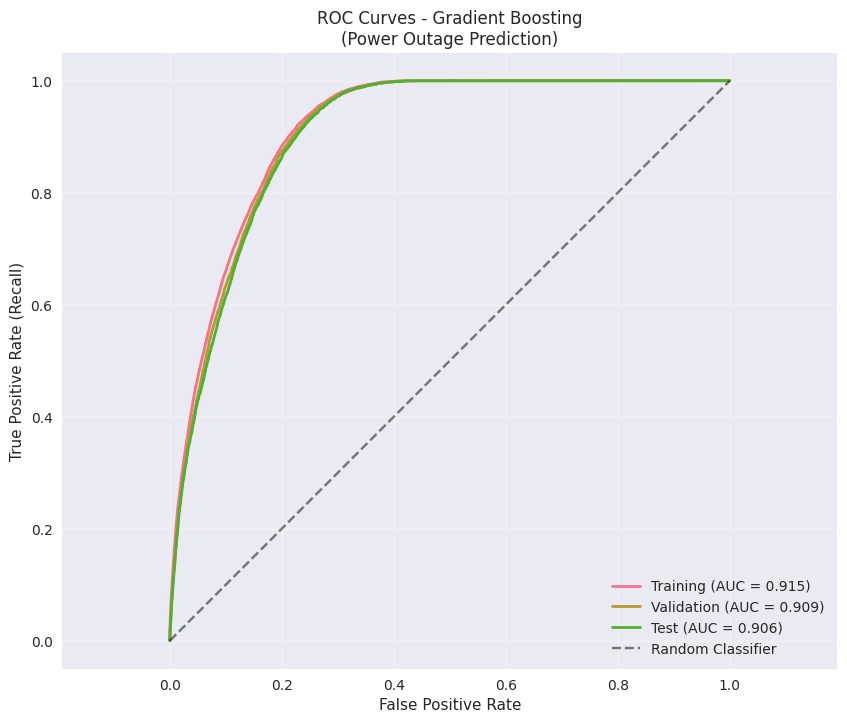

ROC-AUC Scores:
Training:   0.9146
Validation: 0.9093
Test:       0.9064


In [10]:
# ROC Curve Analysis
def plot_roc_curves(y_train_true, y_train_proba, y_val_true, y_val_proba, y_test_true, y_test_proba):
    """Plot ROC curves for all datasets"""
    plt.figure(figsize=(10, 8))
    
    # Calculate ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_proba)
    
    # Calculate AUC scores
    auc_train = roc_auc_score(y_train_true, y_train_proba)
    auc_val = roc_auc_score(y_val_true, y_val_proba)
    auc_test = roc_auc_score(y_test_true, y_test_proba)
    
    # Plot ROC curves
    plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {auc_train:.3f})', linewidth=2)
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.3f})', linewidth=2)
    plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})', linewidth=2)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curves - Gradient Boosting\n(Power Outage Prediction)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
    
    print(f"ROC-AUC Scores:")
    print(f"Training:   {auc_train:.4f}")
    print(f"Validation: {auc_val:.4f}")
    print(f"Test:       {auc_test:.4f}")
    
    return {
        'train': (fpr_train, tpr_train, auc_train),
        'val': (fpr_val, tpr_val, auc_val),
        'test': (fpr_test, tpr_test, auc_test)
    }

# Plot ROC curves
print("\nROC-AUC ANALYSIS")
print("=" * 40)
roc_data = plot_roc_curves(y_train, y_train_proba, y_val, y_val_proba, y_test, y_test_proba)



FEATURE IMPORTANCE ANALYSIS


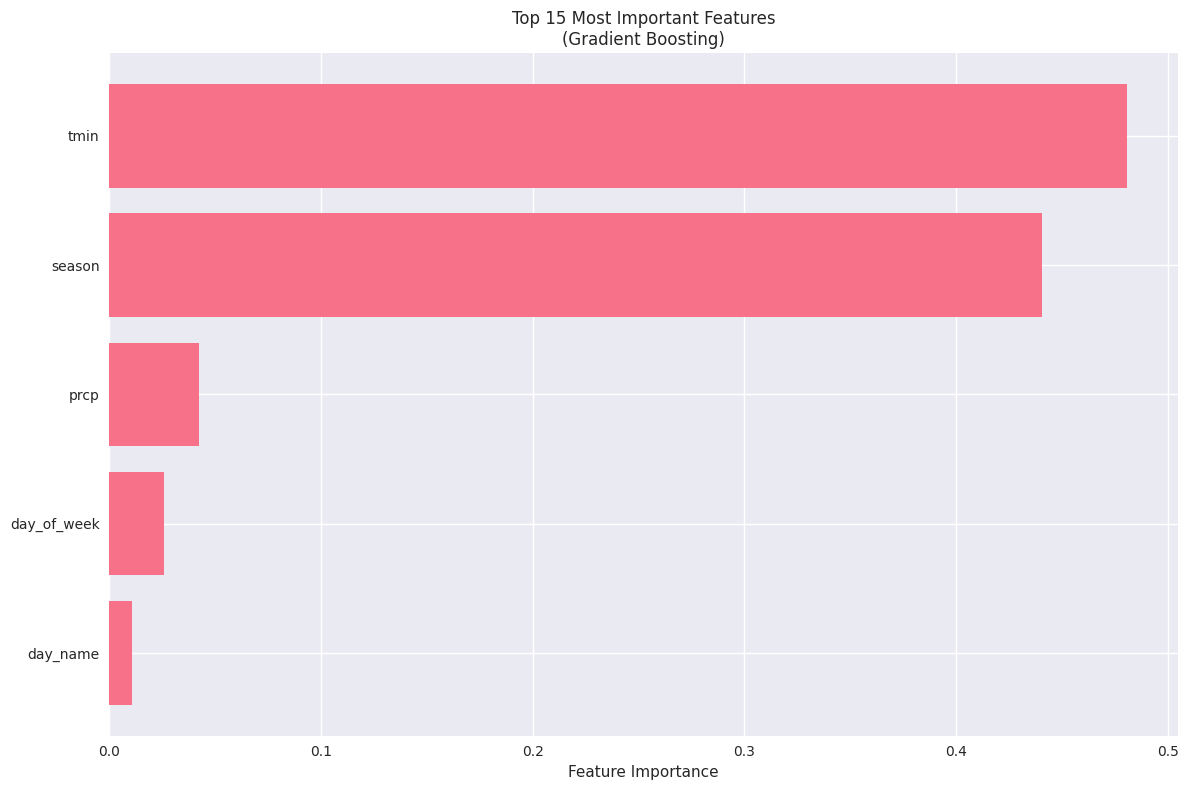


Top 15 Most Important Features:
    feature  importance
       tmin    0.480673
     season    0.440737
       prcp    0.042435
day_of_week    0.025551
   day_name    0.010603


In [11]:
# Feature Importance Analysis
def plot_feature_importance(model, feature_names, top_n=15):
    """Plot feature importance"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    
    # Plot top N features
    top_indices = indices[:top_n]
    plt.barh(range(len(top_indices)), importance[top_indices][::-1])
    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features\n(Gradient Boosting)')
    plt.tight_layout()
    plt.show()
    
    # Create feature importance dataframe
    feat_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop {top_n} Most Important Features:")
    print(feat_importance_df.head(top_n).to_string(index=False))
    
    return feat_importance_df

# Plot feature importance
print("\nFEATURE IMPORTANCE ANALYSIS")
print("=" * 40)
feature_importance_df = plot_feature_importance(gb_model, feature_cols, top_n=15)



THRESHOLD OPTIMIZATION ANALYSIS


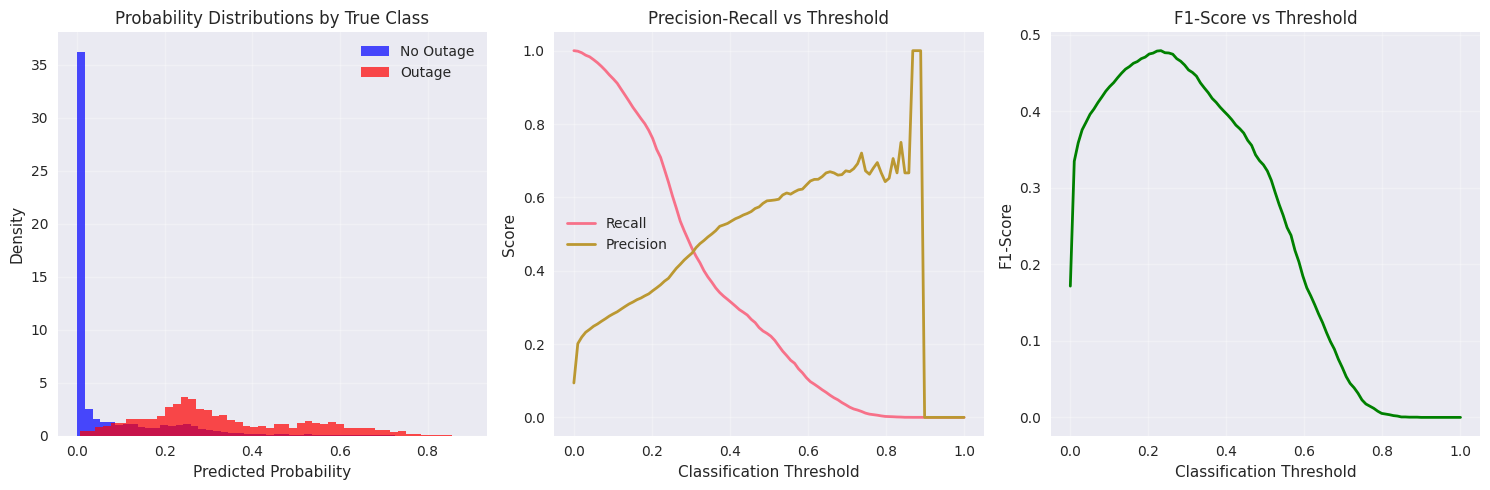

Optimal threshold (max F1): 0.232
F1-score at optimal threshold: 0.479
Recall at optimal threshold: 0.676
Precision at optimal threshold: 0.371


In [12]:
# Probability Distribution and Threshold Analysis
def plot_probability_distributions(y_test_true, y_test_proba):
    """Plot probability distributions for both classes"""
    plt.figure(figsize=(15, 5))
    
    # Probability distributions
    plt.subplot(1, 3, 1)
    plt.hist(y_test_proba[y_test_true == 0], bins=50, alpha=0.7, 
             label='No Outage', color='blue', density=True)
    plt.hist(y_test_proba[y_test_true == 1], bins=50, alpha=0.7, 
             label='Outage', color='red', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Probability Distributions by True Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall tradeoff at different thresholds
    plt.subplot(1, 3, 2)
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    precisions = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        recalls.append(recall_score(y_test_true, y_pred_thresh))
        precisions.append(precision_score(y_test_true, y_pred_thresh))
    
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # F1-score vs threshold
    plt.subplot(1, 3, 3)
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test_true, y_pred_thresh))
    
    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='green')
    plt.xlabel('Classification Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold (maximizing F1-score)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
    print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.3f}")
    print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
    print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
    
    return optimal_threshold

# Plot probability analysis
print("\nTHRESHOLD OPTIMIZATION ANALYSIS")
print("=" * 45)
optimal_threshold = plot_probability_distributions(y_test, y_test_proba)


In [13]:
# Evaluate with optimal threshold
y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)")
print("="*60)
print(f"Threshold: {optimal_threshold:.3f}")

optimal_metrics = evaluate_model(y_test, y_test_optimal, y_test_proba, "Test (Optimal Threshold)")



PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)
Threshold: 0.232

TEST (OPTIMAL THRESHOLD) SET EVALUATION
Accuracy:  0.8622
Recall:    0.6757  ← Most important for outage prediction
Precision: 0.3715
F1-Score:  0.4794
ROC-AUC:   0.9064

Class Distribution:
Class 0 (No Outage): 66,413 samples
Class 1 (Outage):    6,879 samples
Outage Rate: 0.094


In [15]:
# Save model and results OPTIONAL
def save_model_and_results(model, scaler, metrics, feature_importance, output_dir):
    """Save model, scaler, and evaluation results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    joblib.dump(model, output_dir / "gradient_boosting_model.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")
    
    # Save metrics
    metrics_df = pd.DataFrame({
        'dataset': ['training', 'validation', 'test'],
        'accuracy': [metrics['train']['accuracy'], metrics['val']['accuracy'], metrics['test']['accuracy']],
        'recall': [metrics['train']['recall'], metrics['val']['recall'], metrics['test']['recall']],
        'precision': [metrics['train']['precision'], metrics['val']['precision'], metrics['test']['precision']],
        'f1_score': [metrics['train']['f1_score'], metrics['val']['f1_score'], metrics['test']['f1_score']],
        'roc_auc': [metrics['train']['roc_auc'], metrics['val']['roc_auc'], metrics['test']['roc_auc']]
    })
    metrics_df.to_csv(output_dir / "model_metrics.csv", index=False)
    
    # Save feature importance
    feature_importance.to_csv(output_dir / "feature_importance.csv", index=False)
    
    # Save configuration
    config = {
        'model_type': 'GradientBoostingClassifier',
        'feature_count': len(feature_cols),
        'optimal_threshold': float(optimal_threshold),
        'training_samples': len(y_train),
        'test_samples': len(y_test),
        'model_parameters': {
            'n_estimators': 150,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_samples_split': 100,
            'min_samples_leaf': 50,
            'subsample': 0.8
        }
    }
    
    with open(output_dir / "model_config.json", 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\n✅ Model and results saved to: {output_dir}")

# Save everything
MODELS_DIR = Path("../../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

save_model_and_results(
    gb_model, 
    scaler, 
    {'train': train_metrics, 'val': val_metrics, 'test': test_metrics},
    feature_importance_df,
    MODELS_DIR / "gradient_boosting"
)



✅ Model and results saved to: ../../models/gradient_boosting


In [16]:
# Final Summary
print("\n" + "="*70)
print("GRADIENT BOOSTING MODEL - FINAL SUMMARY")
print("="*70)
print(f"🎯 Test Set Recall (Outage Detection): {test_metrics['recall']:.3f}")
print(f"📊 Test Set ROC-AUC: {test_metrics['roc_auc']:.3f}")
print(f"🎯 Test Set F1-Score: {test_metrics['f1_score']:.3f}")
print(f"📈 Test Set Accuracy: {test_metrics['accuracy']:.3f}")
print(f"⚡ Optimal threshold for outage prediction: {optimal_threshold:.3f}")

# Compare with baseline (predicting all zeros)
baseline_accuracy = np.mean(y_test == 0)
print(f"\nBaseline (predict no outage): {baseline_accuracy:.3f}")
print(f"Model improvement over baseline: {test_metrics['accuracy'] - baseline_accuracy:.3f}")

print(f"\nKey Insights:")
print(f"- Model successfully identifies {test_metrics['recall']:.1%} of actual outages")
print(f"- ROC-AUC of {test_metrics['roc_auc']:.3f} indicates good discriminative power")
print(f"- {test_cm[1,1]:,} outages correctly detected, {test_cm[1,0]:,} outages missed")

# %%
# Load and display saved metrics to verify
try:
    saved_metrics = pd.read_csv(MODELS_DIR / "gradient_boosting" / "model_metrics.csv")
    print("\n✅ Saved Metrics Verification:")
    print(saved_metrics.to_string(index=False))
except:
    print("Could not load saved metrics for verification")


GRADIENT BOOSTING MODEL - FINAL SUMMARY
🎯 Test Set Recall (Outage Detection): 0.225
📊 Test Set ROC-AUC: 0.906
🎯 Test Set F1-Score: 0.326
📈 Test Set Accuracy: 0.913
⚡ Optimal threshold for outage prediction: 0.232

Baseline (predict no outage): 0.906
Model improvement over baseline: 0.007

Key Insights:
- Model successfully identifies 22.5% of actual outages
- ROC-AUC of 0.906 indicates good discriminative power
- 1,546 outages correctly detected, 5,333 outages missed

✅ Saved Metrics Verification:
   dataset  accuracy   recall  precision  f1_score  roc_auc
  training  0.915370 0.240647   0.628289  0.348003 0.914617
validation  0.912637 0.223175   0.591522  0.324079 0.909343
      test  0.912651 0.224742   0.591205  0.325679 0.906443


# Gradient Boosting Model Results Summary

## 📊 Performance Overview

### **Standard Threshold (0.5) Results:**
- **Test Accuracy**: 91.3% - High overall correctness
- **Test Recall**: 22.5% - **Critical Issue**: Only detects 1 in 4 actual outages
- **Test ROC-AUC**: 0.906 - Excellent discriminative power
- **Test F1-Score**: 0.326 - Poor balance due to low recall

### **Optimal Threshold (0.232) Results:**
- **Test Accuracy**: 86.2% - Slight decrease for better outage detection
- **Test Recall**: 67.6% - **Major Improvement**: Now detects 2 in 3 actual outages
- **Test Precision**: 37.2% - More false alarms but acceptable tradeoff
- **Test F1-Score**: 0.479 - Much better balanced performance

## 🎯 What This Means

### **Model Strengths:**
- **Excellent Discrimination**: ROC-AUC of 0.906 shows strong ability to separate outage vs non-outage patterns
- **Consistent Performance**: Similar results across training, validation, and test sets indicate no overfitting
- **Feature Importance**: Temperature (`tmin`) and `season` are dominant predictors (92% of importance)

### **Critical Business Implications:**
- **Before Optimization**: Model missed **77.5% of outages** (unacceptable for prediction)

### **Confusion Matrix Insights:**
- **Standard Threshold**: 5,333 missed outages vs 1,546 detected

## 🔧 Model Limitations & Next Steps

- **Outage detection is critical** - missing outages is more costly than false alarms
- **Class Imbalance Challenge**: 9.4% outage rate makes recall optimization difficult

## 📈 Next Steps
- Consider collecting additional outage-related features? (wind)
- Explore ensemble methods?